# MNIST For ML Beginners: The Bayesian way
**(c) 2017 Sreekumar Thaithara Balan and Fergus Simpson, Alpha-I**. 

Download this notebook at: [https://github.com/alpha-i/blog/blob/blog_MNIST_tf_edward_I/notebooks/MNIST_For_ML_Beginners_The_Bayesian_Way.ipynb](https://github.com/alpha-i/blog/blob/blog_MNIST_tf_edward_I/notebooks/MNIST_For_ML_Beginners_The_Bayesian_Way.ipynb)

---

This tutorial is intended for readers who are new to machine learning, TensorFlow and **Bayesian Methods**. Our intension is to create a Bayesian companion to the well known [getting started example](https://www.tensorflow.org/get_started/mnist/beginners) in TensorFlow. 

For more information on a Bayesian perspective, Thomas Wiecki's blog on [Bayesian Deep Learning](http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) and Yarin Gal's blog [What my deep model doesn't know...](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) are extremely useful starting points.

The tutorial requires [TensorFlow](https://www.tensorflow.org/) *version 1.1.0* and [Edward](http://edwardlib.org/) *version 1.3.1*.

## About this tutorial
In this tutorial, we will learn about:

+ How Bayesian statistics is related to machine learning.
+ Constructing a Bayesian model for the classification of MNIST images.
+ Understaning how the Bayesian networks can quantify uncertainties in predictions.

*For those who are eager to see why we care about uncertainties, scroll down to the bottom of this blog where we input the image of the letter **D** and ask our model to classify it. With a Bayesian model we can see how confident we are about our predictions!*

## From Bayes to Brains

In science we sometimes stumble upon a good solution to a problem by chance. For centuries, the paths followed by planets as they wander across the sky was evaluated using an intriguing technique known as epicycles.  An intricate series of gears can be used to predict the movement of the planets with a high degree of accuracy. It worked, even though the underlying concept of the planets rotating around the Earth is flawed.  This approach also lacked flexibility. For example, it would be hopeless at determining the motion of a newly discovered asteroid.

Classical neural networks are the modern day equivalent of epicycles. They are fantastically useful, but their architectures have been derived from many trial-and-error processes: they sorely lack a rigorous theoretical foundation. This has limited their rate of development, since investigations have largely involved a lot of fumbling in the dark. However dramatic advances are possible if we can better understand the fundamental principles at work. Modern astronomy is a good case in point - once we understood that the motions of heavenly bodies are controlled by gravitational forces, we can not only have great confidence in their behaviour, but we can send out spacecraft and predict their motions too.  So, in the context of machine learning, what is the analog of Newton's laws of gravity? What tools can we use to design artificial intelligence at a fundamental level? Remarkably, the answer to this question has been known for decades: Bayesian Neural Networks (BNN). But there is a catch. Unlike the equations of Newton and Kepler, the calculations underpinning Bayesian Neural Networks are typically too complex for even today's supercomputers to handle. Instead researchers have begun to devise approximations to the full-fat BNN calculation. These highly simplistic shortcuts are often accurate enough for our purposes. In fact, as [Gal & Ghahramani](https://arxiv.org/abs/1506.02142) have shown, the popular dropout method  - a regularisation technique employed to avoid overfitting - is one such approximation. 

So what is a Bayesian Neural Network? To understand their nature, we'll begin with a brief outline of Bayesian statistics. At its core, Bayesian statistics is a tool which advises us on how we should alter our beliefs in light of new information. We start with an initial belief (the prior), combine this with the probability of the new data (or likelihood of the model given the new data), and this brings us to our new state of belief (known as the posterior distribution). More formally, the connection between these distributions is given by Bayes theorem:

\begin{equation*}
p(x | D) = p(x) p(D|x) / p(D)
\end{equation*}

Our brain makes use of this all the time. We quickly assess the most likely outcome based on a weighted combination of possibilities. For instance, if we hear the sound of a bear outside, we don't immediately jump to the conclusion that there actually is a grizzly lurking in the street. Because the prior probability of this hypothesis was so low to begin with, we would need very convincing evidence to overcome this belief.

How does this tie in with Bayesian Neural Networks? Rather than fixing the weights of a neural network at a specific value, the Bayesian approach is to treat the weights of the network as variables, each with their own probability distributions. We must begin by imposing some prior belief on the weights $p(w)$. This is typically taken to be a multivariate Gaussian of unit variance, and this in part stems from the normalisation of the input amplitudes. Once our network learns from some training data $D$, our state of knowledge of the weights has a new distribution $p(w | D)$. When presented with a new sample $x$, the probability associated with the output is then given by

\begin{equation*}
p(x | D) = \int \ldots \int  p(x | w) p(w|D) dw_1 \ldots dw_n
\end{equation*}
 
The challenge comes when we wish to compute this integral. There are typically millions of weights in a network so this integral is often unimaginably vast. In this post we shall focus on an example which is simple enough to compute. 


## Importing data
Let us import the [MNIST images](http://yann.lecun.com/exdb/mnist/) using the built in TensorFlow methods.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

In [2]:
# Use the TensorFlow method to download and/or load the data.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True) 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Constructing a Bayesian probabilistic model

The next step in our analysis is to construct a Bayesian model. This is where the we differ from traditional way of thinking. For us, machine learning is an inference problem (see Chapters 39-41 David MacKay's [book](http://www.inference.phy.cam.ac.uk/itprnn/book.html) for a great introduction). Therefore, we need to describe our problem in terms of probabilities. For this purpose we use a framework called [Edward](http://edwardlib.org/). It is built on top of TensorFlow and hence we can easily add a probabilistic programming using TensorFlow-like constructs.

Our machine learning model is a simple soft-max regression described in the TensorFlow getting started example. Since we are "thinking" in terms of probabilities, each parameter in our model has a probability distribution attached to it. We also need a function to quantify the probability of the observed data given a set of parameters (weights and biases in our case). This is called the likelihood of data.

Corresponding to a soft-max regression, we use a Categorical likelihood function (see Chapter 2, [Machine Learning: a Probabilistic Perspective](https://www.cs.ubc.ca/~murphyk/MLbook/) by Kevin Murphy for a detailed description of Categorical distribution, also called Multinoulli distribution.). Why? This is where things get interesting. The combination of the Categorical likelihood and Gaussian priors on the weights and biases results in a log-posterior function which resembles the cross-entropy minimisation with a l2 regulariser (chapter 41 of MacKay's [book](http://www.inference.phy.cam.ac.uk/itprnn/book.html) )! We will not get more into the details now. That we will deal with in another blog post.

In [3]:
ed.set_seed(31415)
N = 100   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

In [4]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y = Categorical(tf.matmul(x,w)+b)

## Making inferences

Now that we have the model defined, we can perform the statistical inference. In the Bayesian paradigm, our inference about the parameters after we have observed the data should be based on the posterior distribution of parameters. Our first task is to characterise the posterior distribution. In this example we will be using Variational Inference (VI) to perform this task. VI algorithms assumes a family of distributions $q(\mathbf{w}, \lambda)$ over parameters $\mathbf{w}$ and try to match their true posterior distribution by optimising parameters $\lambda$. A quick introduction to VI can be found in [Edward's documentation](http://edwardlib.org/tutorials/variational-inference) and a detailed one in [Variational Inference: A Review for Statisticians](https://arxiv.org/abs/1601.00670) by Blei et al.. Chapter 33 or MacKay's [book](http://www.inference.phy.cam.ac.uk/itprnn/book.html) is also a very good reference.

In [5]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K])))) 
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

In [6]:
# We use a place holder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w: qw, b: qb}, data={y:y_ph})

In [7]:
# Initialse the infernce variables
inference.initialize(n_iter=5000, n_print=100, scale={y: float(mnist.train.num_examples) / N})

Now we are ready for the VI. We load up a TensorFlow session and start the iterations. This may take a few minutes...

In [8]:
# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

In [9]:
# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 18208.977


## Evaluating Our Model
We now have everything that we need to run our model on the test data, let's see how good our model is! The major difference in Bayesian model evaluation is that there is no single weight that we should use to evaluate the model. Instead we should use the distribution of weights and biases in our model so that the uncertainties in these parameters are reflected in the final prediction. Thus instead of a single prediction we get a set of predictions and their accuracies.

We draw a 100 samples from the posterior distribution and see how we perform on each of these samples. *Taking samples be might a slow process, may take few seconds!*

In [10]:
# Load the test images.
X_test = mnist.test.images
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.argmax(mnist.test.labels,axis=1)

In [11]:
# Generate samples the posterior and store them.
n_samples = 100
prob_lst = []
samples = []
w_samples = []
b_samples = []
for _ in range(n_samples):
    w_samp = qw.sample()
    b_samp = qb.sample()
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul( X_test,w_samp ) + b_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    samples.append(sample.eval())

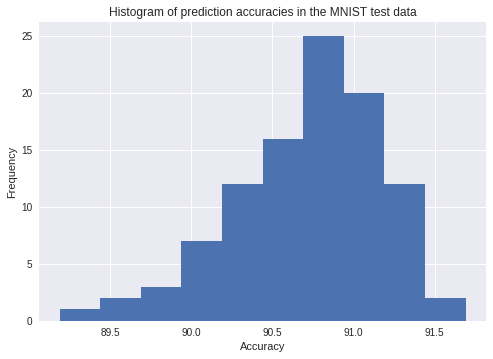

In [12]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

We have a range of accuacies for the samples. Note that posterior distributions of weights and biases refect the information gained from the entire MNIST test data. Thus the above histogram is representative of the uncertainty coming from the statistically possible range of weights and biases.

We can perform a model averaging and try to get a equivalent of a classical machine learning model. We do this by stacking up the predictions of the 100 samples we took from the posterior distribution and then computing the average of the predictions.

In [13]:
# Here we compute the mean of proabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

accuracy in predicting the test data =  92.33


We should also look at the posterior distribution. Unfortunately, the number of dimensions is really **large** even for a small problem like this. So visualising them is tricky! This is where Bayesian methods show their "weakness". We look at the first 5 dimensions and produce a triangle plot of the correlations.

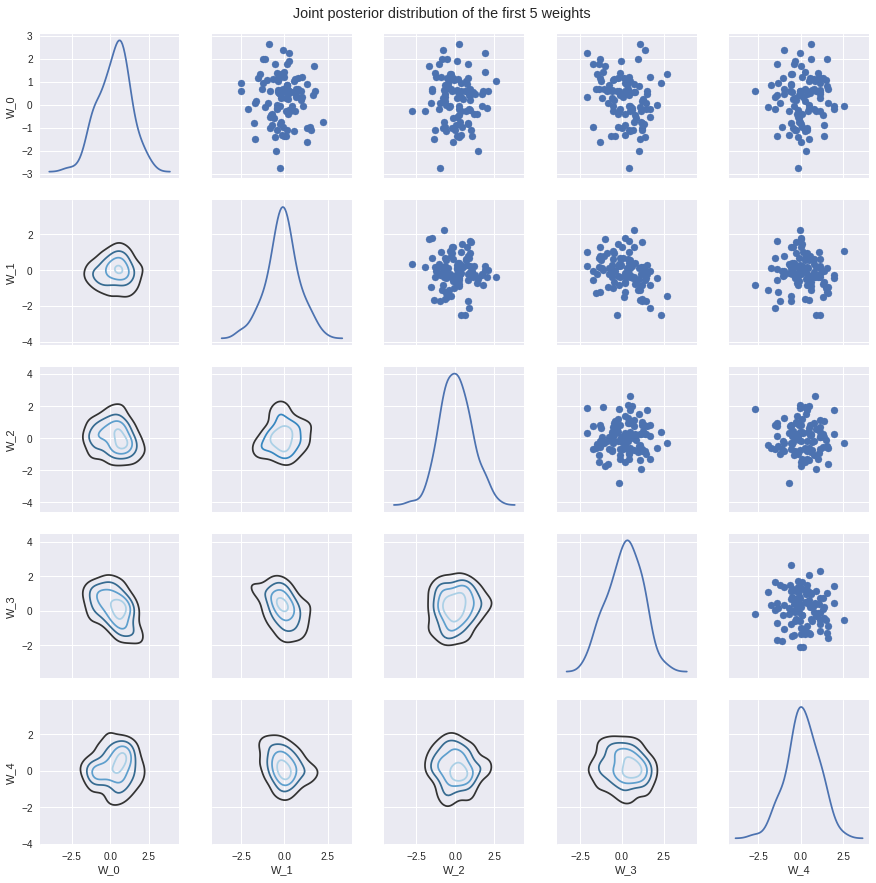

In [14]:
# Create a Pandas DataFrame of posterior samples.
samples_df = pd.DataFrame(data = samples, index=range(n_samples))
# Now create a small subset by taking the first 5 weights, labelled as W_0, ... , W_4.
samples_5 = pd.DataFrame(data = samples_df[list(range(5))].values,columns=["W_0", "W_1", "W_2", "W_3", "W_4"])
# We use Seaborn PairGrid to make a triale plot to show auto and cross correlations.
g = sns.PairGrid(samples_5, diag_sharey=False)
g.map_lower(sns.kdeplot, n_levels = 4,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot,legend=False)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Joint posterior distribution of the first 5 weights')

## Does the model know when it doesn't know?

We borrow the phrase from Yarin Gal and see if we can get a sense of uncertainty in the prediction. We load up an image from the test data and see what classification we get for each sample from the posterior distribution of weights and biases.

truth =  7


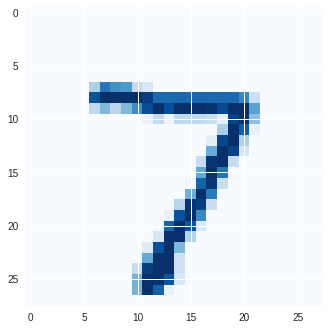

In [15]:
# Load the first image from the test data and its label.
test_image = X_test[0:1]
test_label = Y_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')

In [16]:
# Now the check what the model perdicts for each (w,b) sample from the posterior. This may take a few seconds...
sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( X_test[0:1],w_samp ) + b_samp)
    sing_img_probs.append(prob.eval())


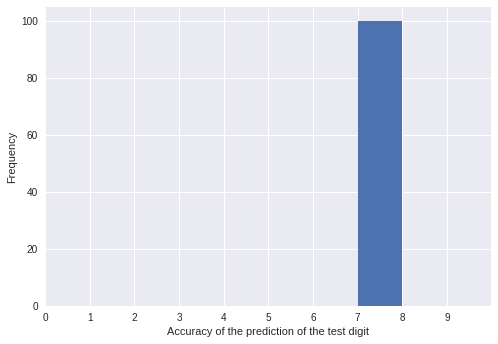

In [17]:
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test digit")
plt.ylabel("Frequency")

As we can see, our model is very confident about the prediction here. For all the samples from the posterior, we predict the true value (this figure may be slightly different in different machines due to the ranom number generation).

What will the model tell us if we give it **completely different data** to that which we have used for training? This is a crucial test as we need to know not only a prediction but also the confidence with which we can claim that prediction. In many Artificial Intelligence applications this information **extremely valuable**. 

For this test we shall use the *notMNIST* data of alphabets and see how our model reacts to this data. We can download the images from [here](http://yaroslavvb.com/upload/notMNIST/). The conversion to MNIST format is described [here](https://github.com/davidflanagan/notMNIST-to-MNIST). In this example we just use the converted data. We assume that all the required files are in the `notMNIST` folder and use the TensorFlow methods.

```bash
git clone git@github.com:davidflanagan/notMNIST-to-MNIST.git
mkdir notMNIST_data
cp notMNIST-to-MNIST/*.gz notMNIST_data
```

We assume that the `notMNIST_data` is in the same directory as this notebook. Since the images are the same format as MNIST, we can use TensorFlow to load the images as before.

<div class="alert alert-danger">
Note that if you haven't executed the bash commands above, TensorFlow method will download the MNIST data into notMNIST_data directory below and you will get the digit 7 as the first image, the instead of the alphabet D from the notMNIST data. Please make sure that you have the correct data in notMNIST_data directory before executing the cell below.
</div>

In [18]:
# As the nonMNIST data is in the same format as MNIST, we can use the TensorFlow functions.
# Please make sure that notMNIST_data directory is in the same directory as this notebook.
# Otherwise, please provide the full path.

### Note that if you haven't executed the bash commands above, TensorFlow method
### WILL download the MNIST data into notMNIST data below and you will get the 
### digit 7 as the first number!
not_mnist = input_data.read_data_sets("./notMNIST_data/", one_hot=True) 

Extracting ./notMNIST_data/train-images-idx3-ubyte.gz
Extracting ./notMNIST_data/train-labels-idx1-ubyte.gz
Extracting ./notMNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./notMNIST_data/t10k-labels-idx1-ubyte.gz


In [19]:
# Load the test images from the data and their leables. 
Xnm_test = not_mnist.test.images
# Once again convert one-hot-vector to the corresponding labels.
Ynm_test = np.argmax(not_mnist.test.labels,axis=1)

Let us now load an image from the notMNIST dataset and ask the model to classify it. As always, we use a set of samples from the posterior to perform the classifications and to see how confident our model is about the prediction.

truth =  3


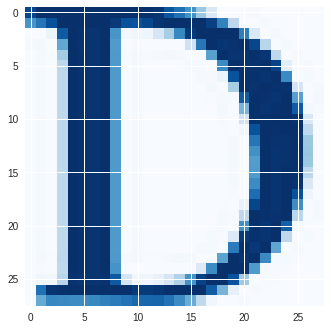

In [20]:
# Load the first image from the notMNIST.
test_image = Xnm_test[0]
test_label = Ynm_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')

In [21]:
# As before, compute the proabilities for each class for all (w,b) samples from the posterior.
nm_sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( Xnm_test[0:1],w_samp ) + b_samp)
    nm_sing_img_probs.append(prob.eval())


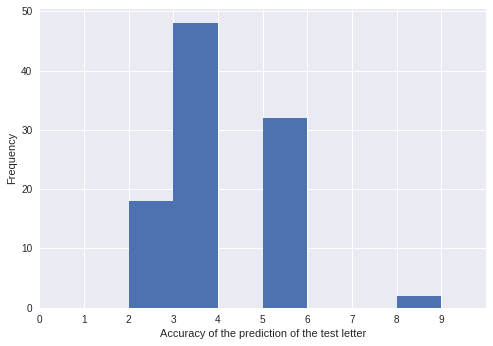

In [22]:
# Now compute the histogram of perdictions from the (w,b) samples.
# In our previous test, all the weights from the posterior was able get the correct prediction.
# However, here we see that the model gives a wide range of possibilites.
# Hence we conclude that its cofidence is lower. 
plt.hist(np.argmax(nm_sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test letter")
plt.ylabel("Frequency")

This histogram shows that the model is not as confident as before about the new classification. This is where the Bayesian methods can add a lot of value compared to the traditional ML methods. What we have shown here is that the posterior distribution of weights can be used to check the confidence with which can classify objects. Model selection (evaluating the relative performance of models) is a big topic in Bayesain methodology and there are methods with which can caluclate the relative odds instead of just looking at a histogram. We will leave those methods for a separate discussion.

## Summary

We have learned to construct a simple Bayesian statistical model for MNIST image classification using TensorFlow and Edward. Understanding uncertainty in statistical inference is very important for a variety of applications and we have explored some basic methods for visualising this problem.

---

*To finish off we watermark our environment. You will need [watermark](https://github.com/rasbt/watermark) iPython [extension](https://ipython.org/ipython-doc/3/config/extensions/index.html) to execute the following.*

In [23]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,edward,tensorflow,seaborn,matplotlib

CPython 3.6.1
IPython 6.0.0

numpy 1.12.1
pandas 0.20.1
edward 1.3.1
tensorflow 1.1.0
seaborn 0.7.1
matplotlib 2.0.2

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.8.0-52-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
